In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import external libraries

In [2]:
import torch
import numpy as np
import scipy.signal
import tensorly as tl
import matplotlib.pyplot as plt

import gc
import time

import internal libraries

In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')

%load_ext autoreload
%autoreload 2
import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers, h5_handling, timeSeries, similarity, math_functions, misc, decomposition, linear_regression, pickle_helpers, cupy_helpers

## make synthetic latents

In [5]:
X_dims_fake = [5000, 200077]
dtype = torch.float32

latents = [
          torch.vstack([torch.sin(torch.linspace(0, 140, X_dims_fake[0]))*2,
                        torch.cos(torch.linspace(2,19,X_dims_fake[0]))*2,
                        torch.linspace(0,1,X_dims_fake[0])*2,
                        torch.cos(torch.linspace(0,17,X_dims_fake[0])) >0]).T*1,
          torch.tensor(scipy.signal.savgol_filter(np.random.rand(X_dims_fake[1], 4), 15, 3, axis=0))-0.5,
        ]

for ii, latent in enumerate(latents):
    latents[ii] = latent.type(dtype)
    

mix latents into data

In [6]:
data_mix = torch.einsum('ij,jk->ik', latents[0], latents[1].T).T

print('data_mix size:')
torch_helpers.tensor_sizeOnDisk(data_mix);

data_mix size:
Device: cpu, Shape: torch.Size([200077, 5000]), Size: 4.00154 GB


show latents and mixed data

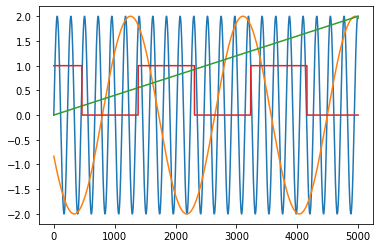

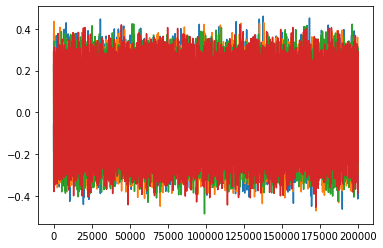

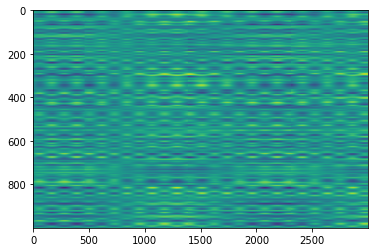

In [7]:
plt.figure()
plt.plot(latents[0])

plt.figure()
plt.plot(latents[1])

plt.figure()
plt.imshow(data_mix[:1000,:3000], aspect='auto')

## Basic PCA

In [8]:
DEVICE = torch_helpers.set_device(use_GPU=True, verbose=False)
X = torch.as_tensor(data_mix, dtype=torch.float32, device=DEVICE)

In [9]:
components_raw, scores_raw, singVals, EVR = decomposition.torch_pca(   X,
                                                               device=DEVICE,
                                                               mean_sub=True,
                                                               zscore=False,
                                                               rank=None,
                                                               return_cpu=True,
                                                               return_numpy=False)

In [11]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

plot PCs

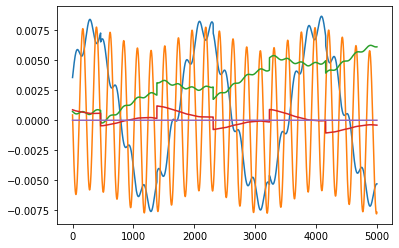

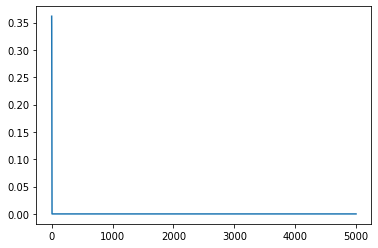

In [12]:
plt.figure()
plt.plot(components_raw[:,:5] * EVR[:5])

plt.figure()
plt.plot(EVR)

## Incremental PCA

In [13]:
from torch.utils.data import Dataset, DataLoader
import cuml

In [14]:
DEVICE = torch_helpers.set_device(use_GPU=False)
cupy_helpers.set_device()

device: 'cpu'
using device: b'GeForce RTX 3090'


0

In [55]:
dataset = decomposition.ipca_dataset(X, 
                                 mean_sub=True,
                                 zscore=False,
                                 preprocess_sample_method='random',
                                 preprocess_sample_num=10000,
                                 device='cpu',
                                 dtype=torch.float32)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, drop_last=True, shuffle=False, num_workers=0, pin_memory=False)

In [56]:
cuml_kwargs = {
                "handle": cuml.Handle(),
                "n_components": 20,
                "whiten": False,
                "copy": False,
                "batch_size": None,
                "verbose": True,
                "output_type": None
}

sk_kwargs = {
                "n_components": 20,
                "whiten": False,
                "copy": False,
                "batch_size": None,
}

tic = time.time()
components, EVR, ipca = decomposition.incremental_pca(dataloader,
                                method='cuml',
                                method_kwargs=cuml_kwargs,
                                return_cpu=True)
print(time.time() - tic)

  0%|          | 0/3126 [00:00<?, ?it/s]

78.2089455127716


<IPython.core.display.Javascript object>


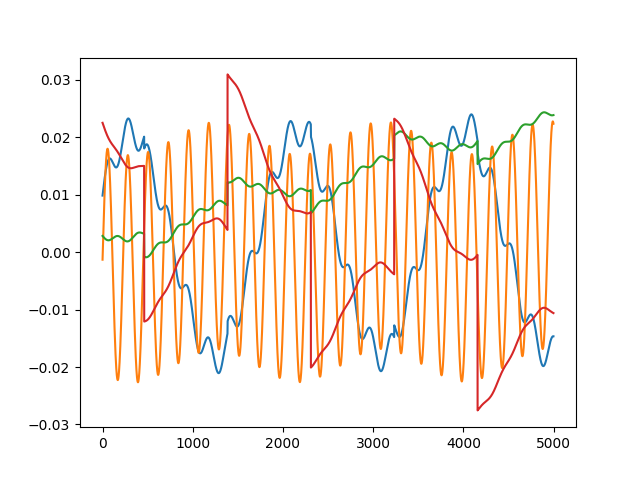

In [57]:
plt.figure()
plt.plot(components[:4].T)

## Compare basic and incremental outputs

<IPython.core.display.Javascript object>


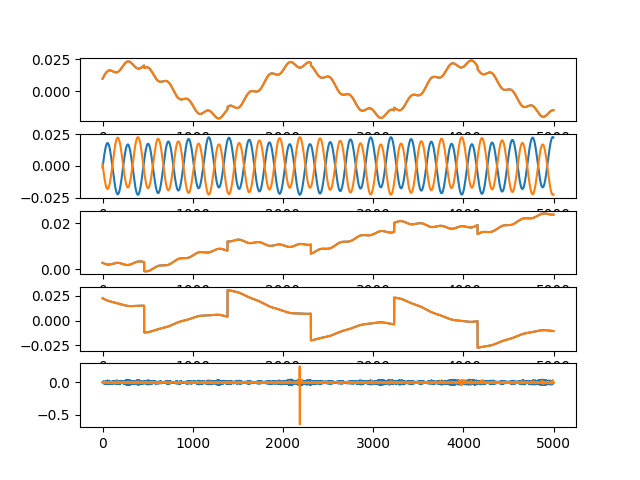

In [58]:
%matplotlib notebook

fig, axs = plt.subplots(5)
for ii in range(len(axs)):
    axs[ii].plot(components[ii])
    axs[ii].plot(components_raw[:,ii])

In [59]:
scores = decomposition.ipca_transform(dataloader, components)

<IPython.core.display.Javascript object>


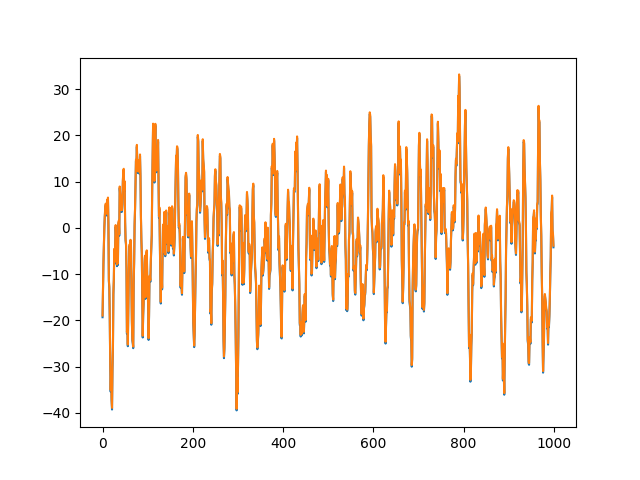

In [60]:
plt.figure()
plt.plot(scores[:1000,0])
plt.plot(scores_raw[:1000,0])